# Task 2

Importiamo df_test_aggregated.pkl

In [426]:
import os
import pandas as pd

path_dataframes = os.path.join("..", "dataset", "dataframes")
file_path = os.path.join(path_dataframes, "df_test_aggregated_with_binary_condition.pkl")

df_test_aggregated = pd.read_pickle(file_path)
df_test_aggregated.head()


,Spacecraft,P1_time_mean,P1_time_median,P1_time_p25,P1_time_p75,P1_time_variance,P1_time_line_integral,P1_time_min,P1_time_max,P1_freq_peak_value,...,P7_time_min,P7_time_max,P7_freq_peak_value,P7_freq_peak_freq,P7_freq_sum_power_spectrum,P7_freq_std_power_spectrum,P7_freq_rms_freq,Case,Window_ID,BinaryCondition
0,1,1.984074,1.968528,1.897964,2.057444,0.089958,791.609870,0.599879,4.409431,1187.765081,...,-0.001597,4.957685,3639.567068,62.50000,25240.991187,404.252030,11.262289,178,1,1
1,1,1.984509,1.963438,1.898697,2.057745,0.090624,791.774258,0.561861,4.411653,1202.301221,...,-0.003549,4.959830,3945.055858,62.50000,23656.785685,391.929474,10.903133,178,2,1
2,1,1.984681,1.963766,1.899070,2.057667,0.090409,793.837928,0.561754,4.411926,1228.619720,...,-0.003637,4.960276,3979.709606,62.34414,23695.311811,390.011746,10.884694,178,3,1
3,1,1.984472,1.960340,1.892148,2.062852,0.093266,791.761654,0.479821,4.100935,1256.382067,...,0.054438,5.082534,4950.370311,65.00000,27089.997640,499.897599,11.667504,179,1,1
4,1,1.985048,1.958879,1.894102,2.063106,0.093737,791.969210,0.453900,4.103057,1253.972941,...,-0.002586,5.085373,5538.603524,65.00000,25996.746576,504.627198,11.429651,179,2,1


Filtro il DataFrame per mantenere solo le righe dove Predicted_BinaryCondition è 1

In [427]:
df_filtered = df_test_aggregated[df_test_aggregated["BinaryCondition"] == 1]

### Step 2.1: Clustering utilizzando due feature

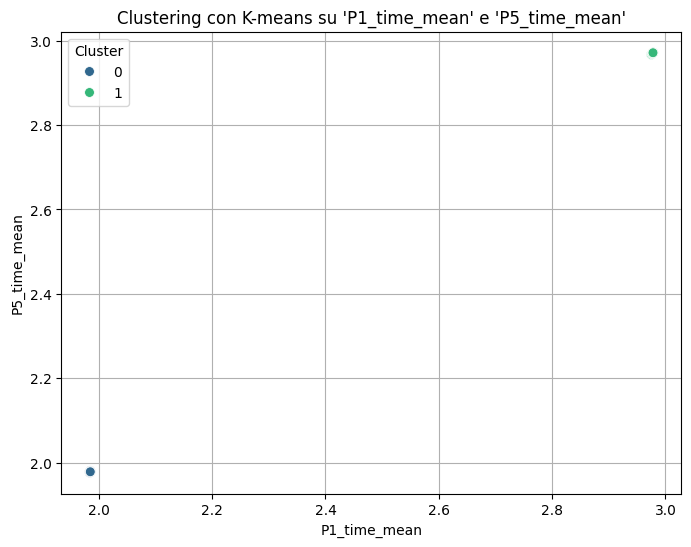

Silhouette (2 feature): 0.9989137055766553


In [428]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Standardizza il dataset completo
scaler_full = StandardScaler()
X_scaled = scaler_full.fit_transform(df_filtered)

# 2. Applica k-means sull'intero dataset standardizzato per ottenere i centroidi
kmeans_full = KMeans(n_clusters=2, random_state=42)
clusters_full = kmeans_full.fit_predict(X_scaled)

# I centroidi sono nello spazio standardizzato
centroids = kmeans_full.cluster_centers_

# 3. Calcola, per ciascuna feature, la differenza assoluta tra i centroidi
feature_names = df_filtered.columns  # elenco delle feature originali
diff = np.abs(centroids[0] - centroids[1])
feature_diff = pd.Series(diff, index=feature_names)

# Seleziona le due feature migliori
top_features = feature_diff.sort_values(ascending=False)

best_feature1 = top_features.index[0]
best_feature2 = top_features.index[1]

# 5. Estrai i dati relativi alle due feature selezionate
X_two = df_filtered[[best_feature1, best_feature2]]

# Standardizza solo queste due feature
scaler_two = StandardScaler()
X_two_scaled = scaler_two.fit_transform(X_two)

# 6. Applica k-means solo sulle due feature selezionate
kmeans_two = KMeans(n_clusters=2, random_state=42)
clusters_two = kmeans_two.fit_predict(X_two_scaled)

# Aggiungi i cluster al DataFrame delle due feature
df_two = X_two.copy()
df_two['Cluster'] = clusters_two

# 7. Visualizza il clustering in un grafico scatter 2D
plt.figure(figsize=(8,6))
sns.scatterplot(x=best_feature1, y=best_feature2, hue='Cluster', data=df_two, palette='viridis', s=50)
plt.title(f"Clustering con K-means su '{best_feature1}' e '{best_feature2}'")
plt.xlabel(best_feature1)
plt.ylabel(best_feature2)
plt.grid(True)
plt.show()

#Verifichiamo la bontà del clustering con il calcolo della silhouette
from sklearn.metrics import silhouette_score
sil_score = silhouette_score(X_two_scaled, clusters_two)
print("Silhouette (2 feature):", sil_score)

In [429]:
df_clusters = df_filtered.copy()
df_clusters['Cluster'] = clusters_two

In [430]:
df_clusters[["Case","Cluster"]]

,Case,Cluster
0,178,0
1,178,0
2,178,0
3,179,0
4,179,0
...,...,...
130,221,0
131,221,0
132,222,1
133,222,1


### Step 2.2: Clustering con PCA

Elimino dal df_filtered le due colonne 'Case' e 'Predicted_BinaryCondition'

In [431]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Salva la colonna "Case" in una variabile 
cases = df_filtered["Case"].copy()

# Crea un DataFrame per il clustering escludendo le colonne "Case" e "Predicted_BinaryCondition"
df_cluster = df_filtered.drop(columns=["Case", "Predicted_BinaryCondition"])

# 1. Standardizza i dati del DataFrame per il clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

# 2. Applica la PCA per ridurre la dimensionalità a 2 componenti
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Crea un DataFrame con le componenti principali per la visualizzazione
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=df_cluster.index)

# 3. Applica k-means sui dati ridotti
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Aggiungi l'assegnazione dei cluster al DataFrame PCA
df_pca['Cluster'] = clusters

# 4. Riaggiungi la colonna "Case" al DataFrame dei risultati
df_pca['Case'] = cases.values

# 5. Visualizza i cluster su un grafico scatter
plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette='viridis', s=50)
plt.title("K-means Clusters sui dati ridotti con PCA")
plt.xlabel("Componente Principale 1")
plt.ylabel("Componente Principale 2")
plt.grid(True)
plt.show()

# Calcola e stampa la silhouette score
sil_score = silhouette_score(X_pca, clusters)
print("Silhouette Score (PCA):", sil_score)

KeyError: "['Predicted_BinaryCondition'] not found in axis"

In [ ]:
df_pca[["Case", "Cluster"]]

,Case,Cluster
0,178,0
1,179,0
6,184,1
8,186,0
10,188,0
12,190,0
14,192,1
15,193,0
18,196,0
19,197,0


## Step 2: Addestrare un Anomaly Detector che individui gli outlier nei dati di test (Unknown)

In [433]:
path_dataframes = os.path.join("..", "dataset", "dataframes")
file_path = os.path.join(path_dataframes, "train_data_aggregated_split.pkl")

df_train_aggregated = pd.read_pickle(file_path)
df_train_aggregated


,Spacecraft,Condition,SV1,SV2,SV3,SV4,BP1,BP2,BP3,BP4,...,P7_time_line_integral,P7_time_min,P7_time_max,P7_freq_peak_value,P7_freq_peak_freq,P7_freq_sum_power_spectrum,P7_freq_std_power_spectrum,P7_freq_rms_freq,Case,Window_ID
0,1,Normal,100,100,100,100,No,No,No,No,...,784.906580,0.017144,5.013518,5020.028779,65.000000,26930.154869,501.116403,11.633031,1,1
1,1,Normal,100,100,100,100,No,No,No,No,...,787.373792,-0.002641,5.016796,5610.686996,65.000000,26048.487157,508.501184,11.441019,1,2
2,1,Normal,100,100,100,100,No,No,No,No,...,789.525599,-0.003006,5.017115,5325.708422,64.837905,26122.284330,501.853078,11.428535,1,3
3,1,Normal,100,100,100,100,No,No,No,No,...,785.214600,-0.002262,4.994830,5071.356039,65.000000,27028.792007,505.424186,11.654316,2,1
4,1,Normal,100,100,100,100,No,No,No,No,...,787.175441,-0.003732,4.999298,5609.065086,65.000000,26860.719421,520.657365,11.618024,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,3,Anomaly,100,100,100,100,No,No,No,No,...,788.615572,0.266961,4.746968,5627.621157,60.000000,27846.049411,497.483160,11.829197,176,2
527,3,Anomaly,100,100,100,100,No,No,No,No,...,790.625595,0.267047,4.747359,5802.848670,59.850374,27917.903116,501.884458,11.814801,176,3
528,3,Anomaly,100,100,100,100,No,No,No,No,...,783.706148,0.008564,5.130090,3916.468924,65.000000,28643.386501,414.984117,11.997359,177,1
529,3,Anomaly,100,100,100,100,No,No,No,No,...,785.382561,-0.003840,5.136178,4246.767660,65.000000,28181.779625,418.906796,11.900293,177,2


Togliamo le righe con Condition == Normal

In [434]:
df_train_aggregated = df_train_aggregated[df_train_aggregated['Condition'] != 'Normal']
df_train_aggregated

,Spacecraft,Condition,SV1,SV2,SV3,SV4,BP1,BP2,BP3,BP4,...,P7_time_line_integral,P7_time_min,P7_time_max,P7_freq_peak_value,P7_freq_peak_freq,P7_freq_sum_power_spectrum,P7_freq_std_power_spectrum,P7_freq_rms_freq,Case,Window_ID
315,1,Fault,0,100,100,100,No,No,No,No,...,787.443747,0.078116,5.022674,3435.995059,65.000000,21376.410718,374.586686,10.364321,106,1
316,1,Fault,0,100,100,100,No,No,No,No,...,788.450749,-0.000695,5.024541,3604.771208,65.000000,20678.566891,371.613295,10.193743,106,2
317,1,Fault,0,100,100,100,No,No,No,No,...,790.664881,-0.000892,5.024811,3375.005753,64.837905,20697.085020,371.103696,10.172779,106,3
318,1,Fault,25,100,100,100,No,No,No,No,...,785.129491,0.016613,5.131036,4874.267686,65.000000,26956.236895,494.105584,11.638663,107,1
319,1,Fault,25,100,100,100,No,No,No,No,...,787.337991,-0.002065,5.133735,5417.301463,65.000000,25812.616693,495.252441,11.389102,107,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,3,Anomaly,100,100,100,100,No,No,No,No,...,788.615572,0.266961,4.746968,5627.621157,60.000000,27846.049411,497.483160,11.829197,176,2
527,3,Anomaly,100,100,100,100,No,No,No,No,...,790.625595,0.267047,4.747359,5802.848670,59.850374,27917.903116,501.884458,11.814801,176,3
528,3,Anomaly,100,100,100,100,No,No,No,No,...,783.706148,0.008564,5.130090,3916.468924,65.000000,28643.386501,414.984117,11.997359,177,1
529,3,Anomaly,100,100,100,100,No,No,No,No,...,785.382561,-0.003840,5.136178,4246.767660,65.000000,28181.779625,418.906796,11.900293,177,2


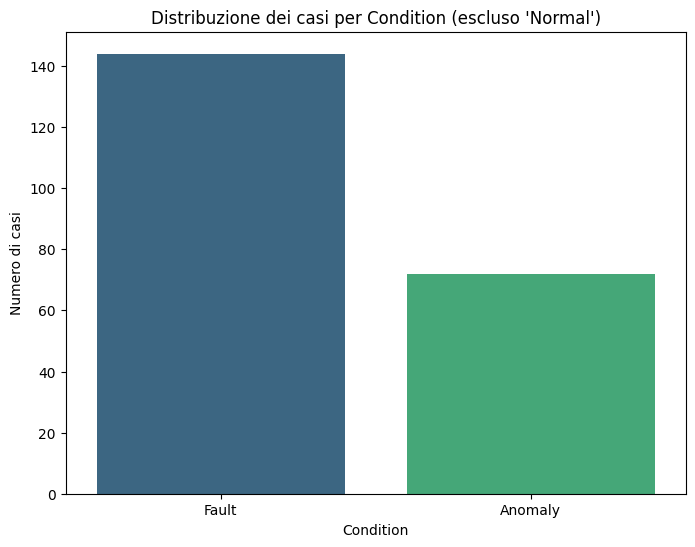

In [435]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

plt.figure(figsize=(8,6))
ax = sns.countplot(x='Condition', data=df_train_aggregated, hue='Condition', palette='viridis', dodge=False)
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("Condition")
plt.ylabel("Numero di casi")
plt.title("Distribuzione dei casi per Condition (escluso 'Normal')")
plt.show()

In [436]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Supponiamo che df_filtered_condition contenga le sole righe con Condition in ["Fault", "Anomaly"]

# 1. Separiamo i due subset
df_fault = df_train_aggregated[df_train_aggregated["Condition"] == "Fault"]
df_anomaly = df_train_aggregated[df_train_aggregated["Condition"] == "Anomaly"]

count_fault = len(df_fault)
count_anomaly = len(df_anomaly)

print(f"Prima del bilanciamento:\nFault = {count_fault}, Anomaly = {count_anomaly}")

# 2. Definiamo la soglia come la media dei conteggi
target = (count_fault + count_anomaly) // 2  # divisione intera

# 3. Se la classe Fault è sopra la soglia, effettuiamo un undersampling
if count_fault > target:
    df_fault = df_fault.sample(n=target, random_state=42)

# 4. Concateniamo le righe di Fault (undersamplate se necessario) e le righe di Anomaly
df_combined = pd.concat([df_fault, df_anomaly], ignore_index=True)

# Ora df_combined è più bilanciato, ma se Anomaly è molto inferiore, non abbiamo ancora abbastanza esempi.
# 5. Applichiamo SMOTE sull'intero df_combined
#    a) Separiamo X e y
X = df_combined.drop(columns=['Spacecraft', 'Condition', 'SV1', 'SV2', 'SV3', 'SV4', 'BP1', 'BP2','BP3', 'BP4',
                                      'BP5', 'BP6','BP7','BV1', 'Window_ID', 'Case'])
y = df_combined["Condition"]

#    b) Usiamo SMOTE per generare esempi sintetici della classe minoritaria
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# 6. Ricostruiamo un DataFrame finale
df_res = pd.concat([pd.DataFrame(X_res, columns=X.columns), 
                    pd.DataFrame(y_res, columns=["Condition"])],
                   axis=1)

# Visualizziamo la distribuzione finale
print("\nDopo l'undersampling + SMOTE:")
print(df_res["Condition"].value_counts())

Prima del bilanciamento:
Fault = 144, Anomaly = 72

Dopo l'undersampling + SMOTE:
Condition
Fault      108
Anomaly    108
Name: count, dtype: int64


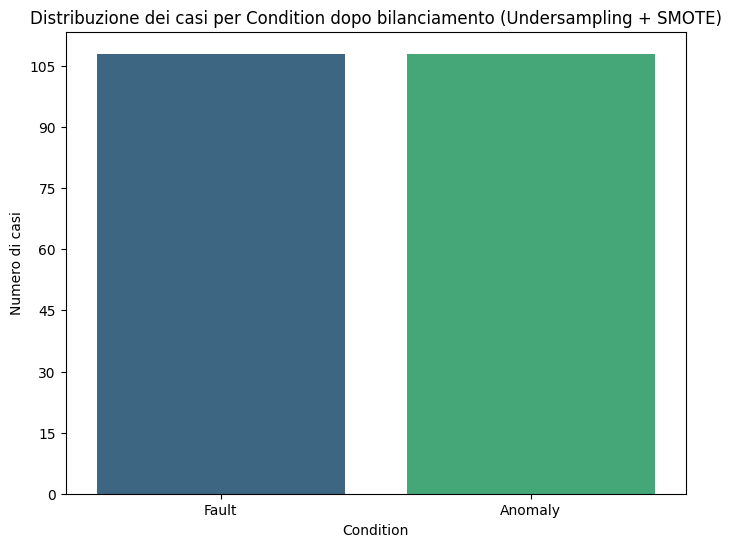

In [437]:
plt.figure(figsize=(8,6))
ax = sns.countplot(x='Condition', data=df_res, hue='Condition', palette='viridis', dodge=False)
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("Condition")
plt.ylabel("Numero di casi")
plt.title("Distribuzione dei casi per Condition dopo bilanciamento (Undersampling + SMOTE)")
plt.show()

In [438]:
df_res

,P1_time_mean,P1_time_median,P1_time_p25,P1_time_p75,P1_time_variance,P1_time_line_integral,P1_time_min,P1_time_max,P1_freq_peak_value,P1_freq_peak_freq,...,P7_time_variance,P7_time_line_integral,P7_time_min,P7_time_max,P7_freq_peak_value,P7_freq_peak_freq,P7_freq_sum_power_spectrum,P7_freq_std_power_spectrum,P7_freq_rms_freq,Condition
0,1.984542,1.956514,1.890168,2.065467,0.086238,791.790153,0.468429,4.178988,1126.551851,65.000000,...,0.404425,784.912248,-0.013318,4.977212,4525.190281,65.000000,32352.330910,466.709516,12.750472,Fault
1,1.985070,1.956094,1.895118,2.061239,0.094660,791.977095,0.449005,4.187168,1266.511956,65.000000,...,0.319269,786.863479,-0.002218,5.018206,5471.636415,65.000000,25541.242810,494.689315,11.329076,Fault
2,1.984979,1.956579,1.892954,2.061909,0.090652,791.938520,0.441206,4.166583,1239.518017,65.000000,...,0.319497,788.006565,-0.000920,4.943366,5554.571261,65.000000,25559.515026,496.400475,11.333127,Fault
3,1.991566,1.961237,1.928978,2.059616,0.056957,794.581496,0.672708,3.609318,828.644762,65.000000,...,0.297853,787.040096,0.001521,4.640653,3134.304040,65.000000,23827.968310,344.200295,10.942510,Fault
4,1.985521,1.958036,1.893264,2.063977,0.092100,794.142736,0.401468,4.292304,1182.092341,64.837905,...,0.314049,789.298674,-0.002745,4.945824,5086.067157,64.837905,25249.676684,474.373437,11.236031,Fault
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,1.984751,1.959205,1.894019,2.056955,0.084260,793.037962,0.562352,4.378988,1089.830547,59.914647,...,0.295080,786.345358,0.062225,4.978981,3685.752547,59.914647,23674.734440,366.120925,10.891014,Anomaly
212,1.984351,1.959963,1.893937,2.058110,0.086267,792.758791,0.776977,4.177080,1136.046502,63.717661,...,0.324801,784.937011,-0.004091,4.926429,4165.099485,63.717661,26048.193245,449.200655,11.424153,Anomaly
213,1.983986,1.960682,1.896442,2.062066,0.084307,791.573600,0.592501,4.205303,1200.247826,62.402930,...,0.324519,785.067952,-0.001204,5.237856,3619.830276,62.402930,25959.082353,400.635975,11.421365,Anomaly
214,1.983463,1.958683,1.891277,2.062152,0.089848,791.391624,0.733489,4.212710,1184.646127,64.611335,...,0.316406,783.912283,-0.002081,4.939433,4231.230577,64.611335,25304.870306,450.143950,11.275253,Anomaly


Iniziamo con l'addestramento del modello

In [439]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# 1. Separazione delle feature e del target
X = df_res.drop(columns=['Condition'])
y = df_res["Condition"]

Top N Feature con ANOVA F-value

Le top 7 feature sono:
['P1_time_mean', 'P1_freq_peak_freq', 'P2_freq_peak_freq', 'P3_freq_peak_freq', 'P5_time_mean', 'P5_freq_peak_freq', 'P7_freq_peak_freq']


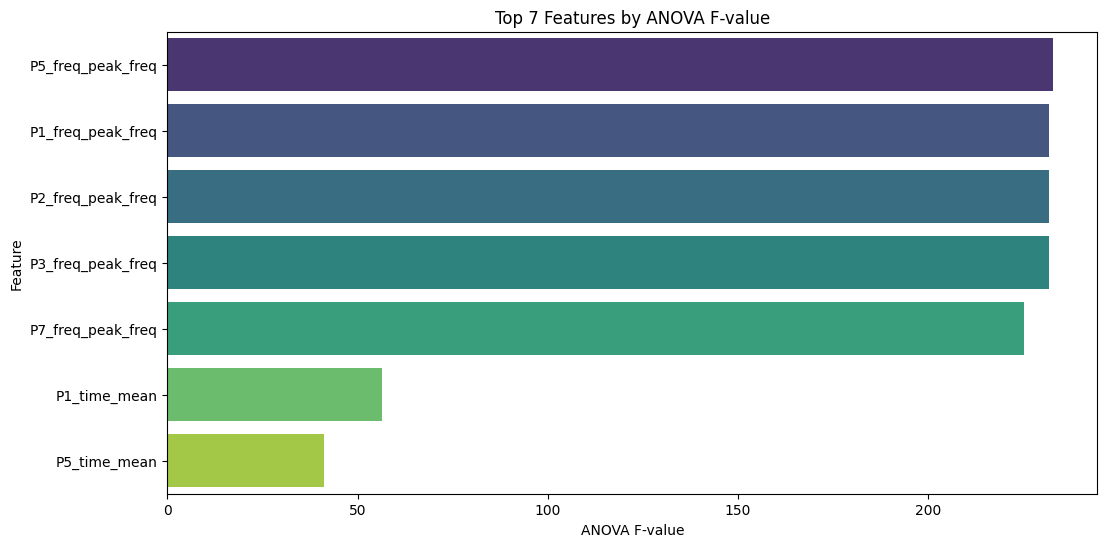

In [440]:
from sklearn.feature_selection import SelectKBest, f_classif

n = 7  # Numero di feature da selezionare
selector = SelectKBest(score_func=f_classif, k=n)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Le top {} feature sono:".format(n))
print(selected_features.tolist())

# 3. Visualizzazione degli F-value delle top n feature tramite istogramma
# Creiamo una Series con gli F-value per tutte le feature
f_scores = pd.Series(selector.scores_, index=X.columns)

# Estraiamo gli F-value solo delle feature selezionate e li ordiniamo in ordine decrescente
topn_f_scores = f_scores[selected_features].sort_values(ascending=False)

plt.figure(figsize=(12,6))
ax = sns.barplot(x=topn_f_scores.values, y=topn_f_scores.index, hue=topn_f_scores.index, palette='viridis', dodge=False)
plt.xlabel("ANOVA F-value")
plt.ylabel("Feature")
plt.title("Top {} Features by ANOVA F-value".format(n))
plt.show()

Mappatura del target

In [441]:
y_numeric = y.map({"Anomaly": 2, "Fault": 3})

Divisione in training e test set

In [442]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# 1. Suddividiamo il dataset in training e test set (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_numeric, test_size=0.2, random_state=42, stratify=y_numeric
)

### Isolation Forest con Decision Function

In [443]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

# 2. Addestriamo l'Isolation Forest sul training set, impostando contamination='auto'
iso_forest = IsolationForest(contamination='auto', random_state=42)
iso_forest.fit(X_train)

# 3. Calcoliamo i punteggi di decisione sul training set per determinare una soglia
train_scores = iso_forest.decision_function(X_train)
# Ad esempio, impostiamo la soglia al 5° percentile dei punteggi di decisione del training set
threshold = np.percentile(train_scores, 4)
print("Soglia scelta:", threshold)

# 4. Applichiamo il modello sul test set per ottenere i punteggi
test_scores = iso_forest.decision_function(X_test)

# 5. Convertiamo i punteggi in etichette: se il punteggio è inferiore alla soglia, etichettiamo il campione come outlier (1), altrimenti come normale (0)
y_pred = np.where(test_scores < threshold, 1, 0)

print(y_pred)

# Accuracy Isolation Forest
outlier_count = np.sum(y_pred == 1)
total_count = len(y_pred)
accuracy_outlier = 1 - (outlier_count / total_count)

print("\nAccuracy per l'individuazione degli outlier:", accuracy_outlier)


Soglia scelta: -0.13144891934565245
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0]

Accuracy per l'individuazione degli outlier: 0.9772727272727273


Predizioni sui dati di test veri

In [444]:
df_test_aggregated = df_test_aggregated[df_test_aggregated["BinaryCondition"] == 1]

In [445]:
# 1. Seleziona solo le feature da utilizzare per la predizione
X_test_pred = df_test_aggregated[selected_features]

# 2. Effettua le predizioni con il modello già addestrato (Isolation Forest)
y_pred_if = iso_forest.predict(X_test_pred)

# 3. Converti le predizioni: -1 (outlier) → 1, 1 (normale) → 0
isUnknown = np.where(y_pred_if == -1, 1, 0)

# 4. Aggiungi la colonna 'isUnknown' al DataFrame di test
df_test_aggregated = df_test_aggregated.copy()  # Per evitare SettingWithCopyWarning
df_test_aggregated['isUnknown'] = isUnknown

# --- Implementazione del Majority Voting per ogni "Case" ---

# Raggruppa per "Case" e prendi la modalità (il valore che compare più frequentemente) per 'isUnknown'
df_majority = df_test_aggregated.groupby("Case")["isUnknown"] \
                .agg(lambda x: x.value_counts().idxmax()) \
                .reset_index()
df_majority

/Users/davidedegrazia/Desktop/C2_PHM_AsiaPacific_2023/phm_env/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


,Case,isUnknown
0,178,0
1,179,0
2,181,0
3,184,1
4,186,0
5,188,0
6,190,0
7,192,1
8,193,0
9,196,0


In [446]:
# 1. Elimina la colonna 'isUnknown' da df_test_aggregated
df_test_aggregated = df_test_aggregated.drop(columns=['isUnknown'], errors='ignore')

# 2. Esegui il merge con df_majority, che contiene le colonne ["Case", "isUnknown"]
df_test_aggregated = pd.merge(
    df_test_aggregated,
    df_majority[['Case', 'isUnknown']],
    on='Case',
    how='left'
)

df_test_aggregated.columns

Index(['Spacecraft', 'P1_time_mean', 'P1_time_median', 'P1_time_p25',
       'P1_time_p75', 'P1_time_variance', 'P1_time_line_integral',
       'P1_time_min', 'P1_time_max', 'P1_freq_peak_value', 'P1_freq_peak_freq',
       'P1_freq_sum_power_spectrum', 'P1_freq_std_power_spectrum',
       'P1_freq_rms_freq', 'P2_time_mean', 'P2_time_median', 'P2_time_p25',
       'P2_time_p75', 'P2_time_variance', 'P2_time_line_integral',
       'P2_time_min', 'P2_time_max', 'P2_freq_peak_value', 'P2_freq_peak_freq',
       'P2_freq_sum_power_spectrum', 'P2_freq_std_power_spectrum',
       'P2_freq_rms_freq', 'P3_time_mean', 'P3_time_median', 'P3_time_p25',
       'P3_time_p75', 'P3_time_variance', 'P3_time_line_integral',
       'P3_time_min', 'P3_time_max', 'P3_freq_peak_value', 'P3_freq_peak_freq',
       'P3_freq_sum_power_spectrum', 'P3_freq_std_power_spectrum',
       'P3_freq_rms_freq', 'P4_time_mean', 'P4_time_median', 'P4_time_p25',
       'P4_time_p75', 'P4_time_variance', 'P4_time_line_inte

## Step: Addestrare un classificatore binario (Random Forest) per classificare Anomaly e Fault

In [447]:
df_res

,P1_time_mean,P1_time_median,P1_time_p25,P1_time_p75,P1_time_variance,P1_time_line_integral,P1_time_min,P1_time_max,P1_freq_peak_value,P1_freq_peak_freq,...,P7_time_variance,P7_time_line_integral,P7_time_min,P7_time_max,P7_freq_peak_value,P7_freq_peak_freq,P7_freq_sum_power_spectrum,P7_freq_std_power_spectrum,P7_freq_rms_freq,Condition
0,1.984542,1.956514,1.890168,2.065467,0.086238,791.790153,0.468429,4.178988,1126.551851,65.000000,...,0.404425,784.912248,-0.013318,4.977212,4525.190281,65.000000,32352.330910,466.709516,12.750472,Fault
1,1.985070,1.956094,1.895118,2.061239,0.094660,791.977095,0.449005,4.187168,1266.511956,65.000000,...,0.319269,786.863479,-0.002218,5.018206,5471.636415,65.000000,25541.242810,494.689315,11.329076,Fault
2,1.984979,1.956579,1.892954,2.061909,0.090652,791.938520,0.441206,4.166583,1239.518017,65.000000,...,0.319497,788.006565,-0.000920,4.943366,5554.571261,65.000000,25559.515026,496.400475,11.333127,Fault
3,1.991566,1.961237,1.928978,2.059616,0.056957,794.581496,0.672708,3.609318,828.644762,65.000000,...,0.297853,787.040096,0.001521,4.640653,3134.304040,65.000000,23827.968310,344.200295,10.942510,Fault
4,1.985521,1.958036,1.893264,2.063977,0.092100,794.142736,0.401468,4.292304,1182.092341,64.837905,...,0.314049,789.298674,-0.002745,4.945824,5086.067157,64.837905,25249.676684,474.373437,11.236031,Fault
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,1.984751,1.959205,1.894019,2.056955,0.084260,793.037962,0.562352,4.378988,1089.830547,59.914647,...,0.295080,786.345358,0.062225,4.978981,3685.752547,59.914647,23674.734440,366.120925,10.891014,Anomaly
212,1.984351,1.959963,1.893937,2.058110,0.086267,792.758791,0.776977,4.177080,1136.046502,63.717661,...,0.324801,784.937011,-0.004091,4.926429,4165.099485,63.717661,26048.193245,449.200655,11.424153,Anomaly
213,1.983986,1.960682,1.896442,2.062066,0.084307,791.573600,0.592501,4.205303,1200.247826,62.402930,...,0.324519,785.067952,-0.001204,5.237856,3619.830276,62.402930,25959.082353,400.635975,11.421365,Anomaly
214,1.983463,1.958683,1.891277,2.062152,0.089848,791.391624,0.733489,4.212710,1184.646127,64.611335,...,0.316406,783.912283,-0.002081,4.939433,4231.230577,64.611335,25304.870306,450.143950,11.275253,Anomaly


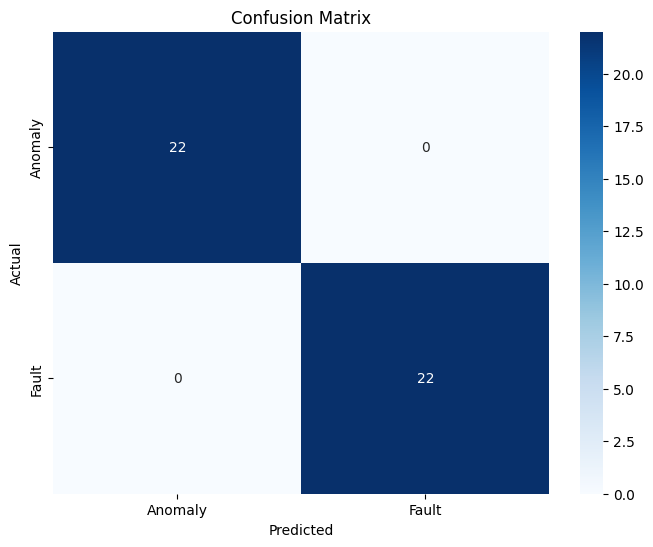

Classification Report:
              precision    recall  f1-score   support

     Anomaly       1.00      1.00      1.00        22
       Fault       1.00      1.00      1.00        22

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44

Accuracy: 1.0


In [448]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Separazione delle feature e del target
X = df_res.drop(columns=['Condition'])
y = df_res['Condition']

# 2. Mappatura dei target: "Anomaly" -> 2, "Fault" -> 3
y = y.map({'Anomaly': 2, 'Fault': 3})

# 3. Suddivisione in training e test set (80% train, 20% test), stratificando per mantenere la distribuzione
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Addestramento del modello Random Forest
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# 5. Predizione sul test set
y_pred = rf_model.predict(X_test)

# 6. Calcolo della matrice di confusione
cm = confusion_matrix(y_test, y_pred, labels=[2, 3])

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Anomaly', 'Fault'],
            yticklabels=['Anomaly', 'Fault'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 7. Visualizzazione delle metriche
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Anomaly', 'Fault']))
print("Accuracy:", accuracy_score(y_test, y_pred))

Previsioni vere sui dati di test (e confronto finale con answer.csv)

In [449]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- Step 1: Filtraggio ---
# Mantieni solo le righe in cui BinaryCondition == 1 e isUnknown == 0
df_filtered = df_test_aggregated[(df_test_aggregated["BinaryCondition"] == 1) & 
                                   (df_test_aggregated["isUnknown"] == 0)].copy()

# --- Step 2: Preparazione dei dati per la predizione ---
# Conserva la colonna "Case" per il majority voting, ma rimuovi le colonne non utili per la predizione.
# Le colonne da rimuovere sono: 'Spacecraft', 'Case', 'Window_ID', 'BinaryCondition', 'PredictedCondition', 'isUnknown'
# Poiché ci serve la colonna "Case" per aggregare le predizioni, la salviamo in una variabile e poi la eliminiamo dai dati di predizione.
cases = df_filtered["Case"]
X_test_pred = df_filtered.drop(columns=['Spacecraft', 'Case', 'Window_ID', 'BinaryCondition', 'PredictedCondition', 'isUnknown'], errors='ignore')

# --- Step 3: Predizioni riga per riga ---
# Utilizza il modello rf_model (già addestrato) per fare predizioni su X_test_pred
# Si assume che il modello sia addestrato per predire il target "Condition" mappato in valori: 2 per "Anomaly" e 3 per "Fault".
y_pred_rows = rf_model.predict(X_test_pred)

# Crea un DataFrame con le predizioni a livello di riga e la relativa "Case"
df_pred = pd.DataFrame({'Case': cases, 'Predicted': y_pred_rows})

# --- Step 4: Majority Voting per ottenere una predizione univoca per ogni Case ---
df_majority = df_pred.groupby("Case")["Predicted"].agg(lambda x: x.value_counts().idxmax()).reset_index()
df_majority.rename(columns={'Predicted': 'whichCondition'}, inplace=True)
df_majority

,Case,whichCondition
0,178,2
1,179,3
2,181,3
3,186,2
4,188,3
5,190,3
6,193,2
7,196,2
8,197,2
9,202,3


In [454]:
all_cases = set(df_test_aggregated["Case"].unique())
cases_majority = set(df_majority["Case"].unique())
remaining_cases = all_cases - cases_majority

# Filtra df_test_aggregated per i casi rimanenti
df_remaining = df_test_aggregated[df_test_aggregated["Case"].isin(remaining_cases)].copy()

# Funzione per assegnare whichCondition ai casi rimanenti
def assign_remaining(group):
    # Se tutte le righe hanno BinaryCondition==0, assegna 0
    if group["BinaryCondition"].nunique() == 1 and group["BinaryCondition"].iloc[0] == 0:
        return 0
    # Se tutte le righe hanno BinaryCondition==1 e isUnknown==1, assegna 1
    elif (group["BinaryCondition"].nunique() == 1 and group["BinaryCondition"].iloc[0] == 1 and 
          group["isUnknown"].nunique() == 1 and group["isUnknown"].iloc[0] == 1):
        return 1
    else:
        # In caso di valori misti, possiamo usare la modalità (o decidere manualmente)
        return group["BinaryCondition"].mode()[0]  # oppure usare un'altra logica

# Applica la funzione di majority voting per i casi rimanenti
remaining_pred = df_remaining.groupby("Case").apply(assign_remaining).reset_index()
remaining_pred.columns = ["Case", "whichCondition"]

# --- Parte 3: Combina i risultati ---
df_final_predictions = pd.concat([df_majority, remaining_pred], ignore_index=True)
df_final_predictions = df_final_predictions.sort_values(by=['Case'])
df_final_predictions

/var/folders/b4/nz58c55x2h757rp1168n491w0000gn/T/ipykernel_78223/2284287679.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  remaining_pred = df_remaining.groupby("Case").apply(assign_remaining).reset_index()


,Case,whichCondition
0,178,2
1,179,3
2,181,3
16,184,1
3,186,2
4,188,3
5,190,3
17,192,1
6,193,2
7,196,2


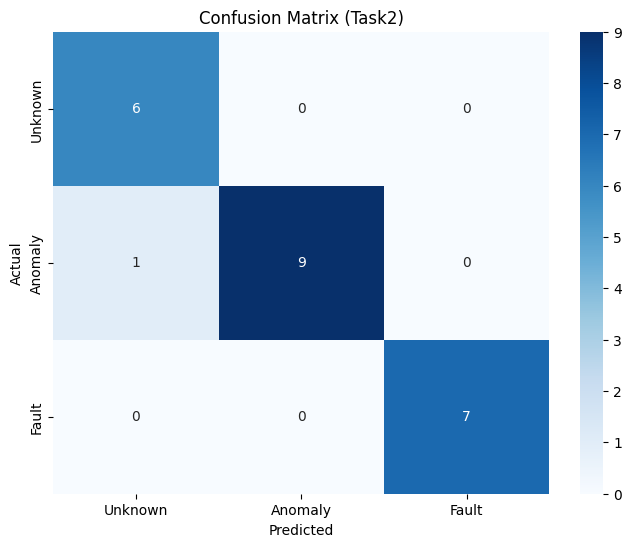

Classification Report:
              precision    recall  f1-score   support

           1       0.86      1.00      0.92         6
           2       1.00      0.90      0.95        10
           3       1.00      1.00      1.00         7

    accuracy                           0.96        23
   macro avg       0.95      0.97      0.96        23
weighted avg       0.96      0.96      0.96        23

Accuracy: 0.9565217391304348


In [457]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# 1. Carica il file answer_competition.csv
df_answer = pd.read_csv("../dataset/test/answer_competition.csv")

# Filtra: rimuovi i casi dove il valore in task2 è 0
df_answer_filtered = df_answer[df_answer["task2"] != 0].copy()

# 2. Unisci il DataFrame con le predizioni (df_final_predictions) con il ground truth filtrato
# Supponiamo che in df_final_predictions la colonna identificativa sia "Case" e in df_answer la colonna sia "ID"
df_compare = pd.merge(df_final_predictions, df_answer_filtered[['ID', 'task2']], 
                      left_on='Case', right_on='ID', how='inner')

# Se non serve la colonna "ID", la eliminiamo e rinominiamo "task2" in "Expected"
df_compare.drop(columns=['ID'], inplace=True)
df_compare.rename(columns={'task2': 'Expected'}, inplace=True)

# 3. Visualizza la Confusion Matrix confrontando le predizioni con il ground truth
# Supponiamo che in df_final_predictions la colonna di predizione sia "whichCondition"
classes = sorted(df_compare["Expected"].unique())
cm = confusion_matrix(df_compare["Expected"], df_compare["whichCondition"], labels=classes)

# Definisci la mappatura
label_map = {1: "Unknown", 2: "Anomaly", 3: "Fault"}

# Supponiamo che 'classes' sia una lista ordinata dei valori numerici (es. [1, 2, 3])
# Mappiamo questi valori nelle etichette desiderate:
mapped_labels = [label_map[c] for c in classes]

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=mapped_labels, yticklabels=mapped_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Task2)")
plt.show()

# 4. Stampa il Classification Report e l'Accuracy
print("Classification Report:")
print(classification_report(df_compare["Expected"], df_compare["whichCondition"]))
print("Accuracy:", accuracy_score(df_compare["Expected"], df_compare["whichCondition"]))

Esportiamo il modello in formato .pkl

In [458]:
import pickle

with open("fault_vs_anomaly_classifier.pkl", "wb") as f:
    pickle.dump(rf_model, f)

Aggiungiamo predizioni ai dati di test

In [468]:
import os
import pandas as pd

path_dataframes = os.path.join("..", "dataset", "dataframes")
file_path = os.path.join(path_dataframes, "test_data_aggregated_split.pkl")

df_test_aggregated = pd.read_pickle(file_path)
df_test_aggregated.head()

,Spacecraft,P1_time_mean,P1_time_median,P1_time_p25,P1_time_p75,P1_time_variance,P1_time_line_integral,P1_time_min,P1_time_max,P1_freq_peak_value,...,P7_time_line_integral,P7_time_min,P7_time_max,P7_freq_peak_value,P7_freq_peak_freq,P7_freq_sum_power_spectrum,P7_freq_std_power_spectrum,P7_freq_rms_freq,Case,Window_ID
0,1,1.984074,1.968528,1.897964,2.057444,0.089958,791.609870,0.599879,4.409431,1187.765081,...,784.721639,-0.001597,4.957685,3639.567068,62.50000,25240.991187,404.252030,11.262289,178,1
1,1,1.984509,1.963438,1.898697,2.057745,0.090624,791.774258,0.561861,4.411653,1202.301221,...,787.517554,-0.003549,4.959830,3945.055858,62.50000,23656.785685,391.929474,10.903133,178,2
2,1,1.984681,1.963766,1.899070,2.057667,0.090409,793.837928,0.561754,4.411926,1228.619720,...,789.760005,-0.003637,4.960276,3979.709606,62.34414,23695.311811,390.011746,10.884694,178,3
3,1,1.984472,1.960340,1.892148,2.062852,0.093266,791.761654,0.479821,4.100935,1256.382067,...,785.035029,0.054438,5.082534,4950.370311,65.00000,27089.997640,499.897599,11.667504,179,1
4,1,1.985048,1.958879,1.894102,2.063106,0.093737,791.969210,0.453900,4.103057,1253.972941,...,787.510919,-0.002586,5.085373,5538.603524,65.00000,25996.746576,504.627198,11.429651,179,2


In [470]:
# Eseguiamo il merge su "Case". Usiamo una left join in modo da mantenere tutte le righe di df_test_aggregated.
df_merged = pd.merge(df_test_aggregated, df_compare[['Case', 'whichCondition']],
                     on='Case', how='left')

# Per i casi che non sono presenti in df_compare, sostituiamo il valore con 0
df_merged['whichCondition'] = df_merged['whichCondition'].fillna(0).astype(int)

# Rinominiamo la colonna "whichCondition" in "Condition"
df_merged.rename(columns={'whichCondition': 'Condition'}, inplace=True)
df_merged

,Spacecraft,P1_time_mean,P1_time_median,P1_time_p25,P1_time_p75,P1_time_variance,P1_time_line_integral,P1_time_min,P1_time_max,P1_freq_peak_value,...,P7_time_min,P7_time_max,P7_freq_peak_value,P7_freq_peak_freq,P7_freq_sum_power_spectrum,P7_freq_std_power_spectrum,P7_freq_rms_freq,Case,Window_ID,Condition
0,1,1.984074,1.968528,1.897964,2.057444,0.089958,791.609870,0.599879,4.409431,1187.765081,...,-0.001597,4.957685,3639.567068,62.500000,25240.991187,404.252030,11.262289,178,1,2
1,1,1.984509,1.963438,1.898697,2.057745,0.090624,791.774258,0.561861,4.411653,1202.301221,...,-0.003549,4.959830,3945.055858,62.500000,23656.785685,391.929474,10.903133,178,2,2
2,1,1.984681,1.963766,1.899070,2.057667,0.090409,793.837928,0.561754,4.411926,1228.619720,...,-0.003637,4.960276,3979.709606,62.344140,23695.311811,390.011746,10.884694,178,3,2
3,1,1.984472,1.960340,1.892148,2.062852,0.093266,791.761654,0.479821,4.100935,1256.382067,...,0.054438,5.082534,4950.370311,65.000000,27089.997640,499.897599,11.667504,179,1,3
4,1,1.985048,1.958879,1.894102,2.063106,0.093737,791.969210,0.453900,4.103057,1253.972941,...,-0.002586,5.085373,5538.603524,65.000000,25996.746576,504.627198,11.429651,179,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,4,2.978057,2.961954,2.859923,3.065790,0.120270,1188.275026,1.273844,5.548642,1686.126450,...,0.871102,6.172795,5729.758837,62.500000,31836.358832,570.967320,12.648387,222,2,1
134,4,2.978087,2.961726,2.860031,3.065741,0.119986,1191.265111,1.273551,5.548942,1659.784916,...,0.871021,6.173302,5669.418055,62.344140,31919.247891,569.120817,12.633141,222,3,1
135,4,1.984437,1.954944,1.890076,2.063283,0.091549,791.746170,0.462211,4.458880,1260.682647,...,-0.005567,4.982829,4885.478884,65.000000,27332.786863,485.526656,11.719671,223,1,0
136,4,1.985151,1.955205,1.891485,2.063537,0.091799,792.005479,0.442557,4.461158,1262.838840,...,-0.005754,4.986839,5411.286990,65.000000,25965.069502,484.843258,11.422685,223,2,0


In [471]:
# Salviamo il df risultante in pkl e csv per utilizzarlo nel task3 poi
df_merged.to_csv("../dataset/dataframes/test_aggregated_split_with_condition.csv", index=False)
df_merged.to_pickle("../dataset/dataframes/test_aggregated_split_with_condition.pkl")